In [198]:
#Written by Sungwook Hong
#MSFE2017. Univ. of Illinois 

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import datetime
import pandas_datareader.data as web
import quandl

quandl.ApiConfig.api_key = "KuL7iL8zUg7h8iZzXh9_"

#def gen_stock_info(ticker, start, end):
def gen_stock_info():
    #stock_df = quandl.get(''.join(['WIKI/', ticker]), start_date=start, end_date=end)
    stock_df=quandl.get("BCHARTS/BITSTAMPUSD")
    stock_df = stock_df[(stock_df['Open'] != 0) & (stock_df['Close'] != 0)]
    return stock_df  #only need some columns


def add_Moving_Ave(stock_df):
    ma_list = ['ma5','ma20', 'ma60', 'ma120']
    window_list = [5, 20, 60, 120]
    for ma, window_ in zip(ma_list, window_list):
        stock_df[ma] = stock_df['Close'].rolling(window=window_).mean()
    return stock_df
    
    
def add_STD(stock_df):
    std_list = ['std_20']
    window_list = [20]
    for std, window_ in zip(std_list, window_list):
        stock_df[std] = stock_df['Close'].rolling(window=window_).std()
    return stock_df


def draw_stock(stock_df, window_=365):

    plt.figure(figsize=(10,6))
    plt.plot(stock_df.index[-window_:],stock_df.Close[-window_:],label='Close')
    plt.plot(stock_df.index[-window_:],stock_df.ma5[-window_:],label='ma5')
    plt.plot(stock_df.index[-window_:],stock_df.ma20[-window_:],label='ma20')
    #plt.plot(stock_df.index[-window_:],stock_df.ma60[-window_:],label='ma60')
    #plt.plot(stock_df.index[-window_:],stock_df.ma120[-window_:],label='ma120')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

#functions for analysis of an algorithm after simulations    
#############################   
def gen_drawdown_record(list_, K): # including up to K-th largest one
    
    record_ =[] 
    for i in range(1, len(list_)-1):
        if list_[i] > list_[i+1] and list_[i] > list_[i-1]: #find some number that are greater than the numbers next to it
            
            max_ = 0
            num_of_found = 0
            j = i+1
            while (num_of_found == 0) & (j < len(list_)):  #I can only look at the values from current point to the end
                if list_[i] <= list_[j]: #This is when I find the value recovered
                    num_of_found += 1
                    
                    if num_of_found == 1: # just make sure if the value is the first recovery found
                        min_ = np.min(list_[i+1:j]) #Then between the start and the recovery, there should be a minimum 
                        k_index = stock_df.index.tolist().index(np.argmin(list_[i+1:j]))      
                        record_.append(((list_[i]-min_)/list_[i], i, k_index)) 
                j = j+1
                if j == len(list_):
                    min_ = min(list_[i:])
                    min_index = stock_df.index.tolist().index(np.argmin(list_[i:]))
                    if (list_[i]-min_)/list_[i] > max_:
                        max_ = (list_[i]-min_)/list_[i]
                        record_.append((max_, i, min_index))
    if K > len(record_):
        return "K is greater than the number of drawdowns"
    else:        
        return sorted(record_, key= lambda pair:pair[0], reverse = True)[:K]
    
    
def draw_result_of_sim(stock_df, record_):
    plt.figure(figsize=(10,6))
    plt.plot(stock_df['Close'], label='Close')
    plt.plot(stock_df['Total_asset'],label='Total_asset')
    plt.plot(stock_df['Net_profit'],label='Net_profit')
    plt.plot(stock_df.index[record_[1]], stock_df['Total_asset'][record_[1]], 'o', color='black')
    plt.plot(stock_df.index[record_[2]], stock_df['Total_asset'][record_[2]], 'o', color='black')
    plt.title('Bollinger Band strategy with targeted portion plus loss-cut')
    plt.xlabel('Time')
    plt.ylabel('In Dollars')
    plt.legend(loc='best')
    plt.show()

    
def draw_return_dist(stock_df):
    dailyreturn = np.log(stock_df.Close)-np.log(stock_df.Close.shift(1))
    day_ret = np.array(dailyreturn[1:])
    import seaborn as sns
    from scipy import stats
    sns.distplot(day_ret, kde=True, rug=True, fit=stats.norm)    

def calc_quality_of_port(stock_df):
    return (stock_df.Cum_profit).mean()/(stock_df.Cum_profit).std()

def calc_max_drawdown(stock_df):
    max_drawdown, start_point, end_point = gen_drawdown_record(stock_df.Total_asset, 1)[0]
    return -round(max_drawdown*100), start_point, end_point

def get_final_total_value(stock_df):
    return stock_df.Cum_profit[-1]

#generate the stock info
stock_df = gen_stock_info()
stock_df = add_Moving_Ave(stock_df)
stock_df = add_STD(stock_df)
stock_df = stock_df.iloc[:,[0, 1, 2, 3, 7, 8, -1]]
stock_df = stock_df.iloc[20:,:]
ref_stock_df = stock_df.copy()


/Users/Sungwookhong/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


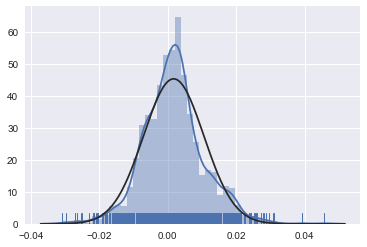

In [142]:
#plt.hist((stock_df['Close']-stock_df['ma20'])/stock_df['std_20'], 100)
#plt.hist(((stock_df['ma20'] - stock_df['ma20'].shift(1))/stock_df['ma20'])[1:], 100)
dailyreturn = np.log(stock_df.ma20)-np.log(stock_df.ma20.shift(1))
day_ret = np.array(dailyreturn[1:])
import seaborn as sns
from scipy import stats
sns.distplot(day_ret, kde=True, rug=True, fit=stats.norm) 


In [194]:
def simulate_algo(ref_stock_df, init_cash = 1000, target_port_ratio=0.5, loss_cut_ratio = 0.95):
# init_cash = 1000
# target_port_ratio = 0.5
# loss_cut_ratio = 0.95 #if the total asset is losing 5% during the day, it stops the trading.  
    stock_df = ref_stock_df.copy()
    stock_df.loc[:,'Cash']=0  
    stock_df.at[stock_df.index[0],'Cash']=init_cash
    stock_df.loc[:,'Inventory']=0
    stock_df.loc[:,'Port_val']=0
    stock_df.loc[:,'Total_asset']=0
    stock_df.at[stock_df.index[0],'Total_asset'] = stock_df.iloc[0]['Cash']+stock_df.iloc[0]['Port_val']
    stock_df.loc[:,'Net_profit']=0
    stock_df.loc[:,'Signal'] = 0

    def short(quantity, list_):
        open_t, high_t, low_t, close_t, Cash_t, Inventory_t = list_

        Inventory_t = Inventory_t - quantity 
        Cash_t = Cash_t + quantity * open_t
        Port_val_t = Inventory_t * close_t
        Total_asset_t = Cash_t + Port_val_t 
        Net_profit_t = Total_asset_t - Total_asset_y

        return Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t


    def long(quantity, list_):
        open_t, high_t, low_t, close_t, Cash_t, Inventory_t = list_ 

        Inventory_t = Inventory_t + quantity 
        Cash_t = Cash_t - quantity * open_t
        Port_val_t = Inventory_t * close_t
        Total_asset_t = Cash_t + Port_val_t 
        Net_profit_t = Total_asset_t - Total_asset_y

        return Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t


    def clear_position(quantity, list_):
        open_t, high_t, low_t, close_t, Cash_y, Inventory_y = list_

        if Inventory_y < 0: #clear some short positions
            Inventory_t = Inventory_y + quantity 
            Cash_t = Cash_y - quantity * open_t
            Port_val_t = Inventory_t * close_t
            Total_asset_t = Cash_t + Port_val_t 
            Net_profit_t = Total_asset_t - Total_asset_y

        elif Inventory_y > 0: #clear some long positions
            Inventory_t = Inventory_y - quantity 
            Cash_t = Cash_y + quantity * open_t
            Port_val_t = Inventory_t * close_t
            Total_asset_t = Cash_t + Port_val_t 
            Net_profit_t = Total_asset_t - Total_asset_y

        return Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t  



    for i in range(1,len(stock_df)): 
        known_yesterday = stock_df.iloc[i-1,:] # all info
        known_today = stock_df.iloc[i,0] #only open price at the start of the market
        unknown_today = stock_df.iloc[i,1:4]
        open_y, high_y, low_y, close_y, ma5_y, ma20_y, std20_y, Cash_y, Inventory_y, Port_val_y, Total_asset_y, Net_profit_y, Signal_y = known_yesterday
        open_t = known_today
        high_t, low_t, close_t = unknown_today
        ref_list = (open_t, high_t, low_t, close_t, Cash_y, Inventory_y)
        targeted_quantity = Total_asset_y * target_port_ratio/open_t

        if Inventory_y == 0:
            if close_y >= ma20_y + std20_y:
                stock_df.loc[stock_df.index[i],'Signal'] = 1
                stock_df.iloc[i,[7, 8, 9, 10, 11]] = long(targeted_quantity, ref_list)

            elif close_y <= ma20_y - std20_y:
                stock_df.loc[stock_df.index[i],'Signal'] = -1
                stock_df.iloc[i,[7, 8, 9, 10, 11]] = short(targeted_quantity, ref_list)
            else:
                stock_df.iloc[i,[7, 8, 9, 10]] = stock_df.iloc[i-1,[7, 8, 9, 10]]
                stock_df.iloc[i,11] = 0 

        elif Inventory_y > 0:
            if close_y < ma5_y:
                stock_df.loc[stock_df.index[i],'Signal'] = 2  #clear the long positions
                stock_df.iloc[i,[7, 8, 9, 10, 11]] = clear_position(abs(Inventory_y), ref_list)

            elif Inventory_y >= targeted_quantity:
                stock_df.iloc[i,[7, 8, 9, 10, 11]] = clear_position(Inventory_y-targeted_quantity, ref_list)

            elif Inventory_y < targeted_quantity:    
                stock_df.iloc[i,[7, 8, 9, 10, 11]] = long(targeted_quantity - abs(Inventory_y), ref_list)
        

        elif Inventory_y < 0:
            if close_y > ma5_y:
                stock_df.loc[stock_df.index[i],'Signal'] = -2  #clear the short positions
                stock_df.iloc[i,[7, 8, 9, 10, 11]] = clear_position(abs(Inventory_y), ref_list)

            elif abs(Inventory_y) >= targeted_quantity:
                stock_df.iloc[i,[7, 8, 9, 10, 11]] = clear_position(abs(Inventory_y)-targeted_quantity, ref_list)

            elif abs(Inventory_y) < targeted_quantity: 
                stock_df.iloc[i,[7, 8, 9, 10, 11]] = short(targeted_quantity - abs(Inventory_y), ref_list)
        
        Cash_t, Inventory_t = stock_df.iloc[i,7], stock_df.iloc[i,8]
        if (Inventory_t > 0) & ((Cash_t + low_t*Inventory_t) <= loss_cut_ratio*Total_asset_y):  
            traded_price = (loss_cut_ratio*Total_asset_y-Cash_t)/abs(Inventory_t)
            Cash_t = Cash_t + traded_price*abs(Inventory_t)
            Inventory_t = 0
            Port_val_t = 0 
            Total_asset_t = Cash_t + Port_val_t
            Net_profit_t = Total_asset_t - Total_asset_y
            stock_df.iloc[i,[7, 8, 9, 10, 11]] = Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t      


        elif (Inventory_t < 0) & ((Cash_t + high_t*Inventory_t) <= loss_cut_ratio*Total_asset_y):   # if happens right after we sell
            traded_price = (loss_cut_ratio*Total_asset_y-Cash_t)/Inventory_t
            Cash_t = Cash_t + traded_price*Inventory_t
            Inventory_t = 0
            Port_val_t = 0 
            Total_asset_t = Cash_t + Port_val_t
            Net_profit_t = Total_asset_t - Total_asset_y
            stock_df.iloc[i,[7, 8, 9, 10, 11]] = Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t
            
                
    stock_df['Cum_profit']=stock_df['Net_profit'].cumsum()
    return stock_df

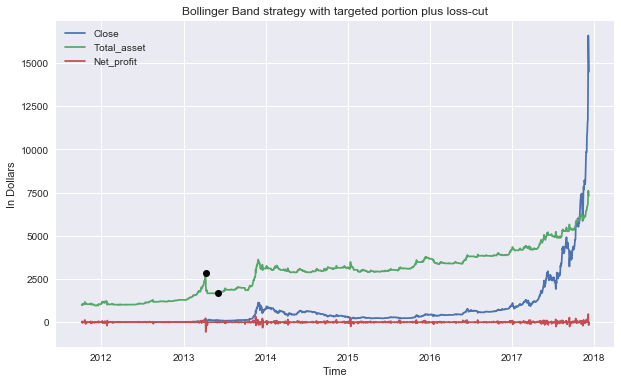

           Targeted portion = 0.3 , Loss cut = 0.8
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 6321.54
           The Quality of the Portfolio is 1.47
           Max Drawdown is -40.0 %


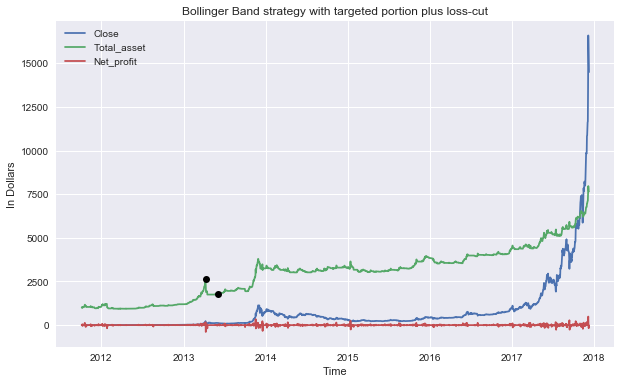

           Targeted portion = 0.3 , Loss cut = 0.85
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 6660.65
           The Quality of the Portfolio is 1.44
           Max Drawdown is -32.0 %


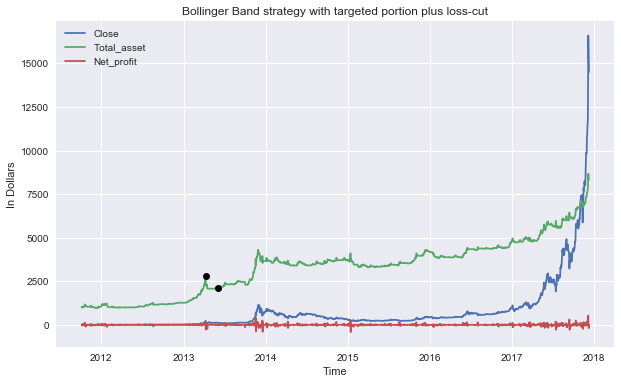

           Targeted portion = 0.3 , Loss cut = 0.9
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 7333.54
           The Quality of the Portfolio is 1.51
           Max Drawdown is -25.0 %


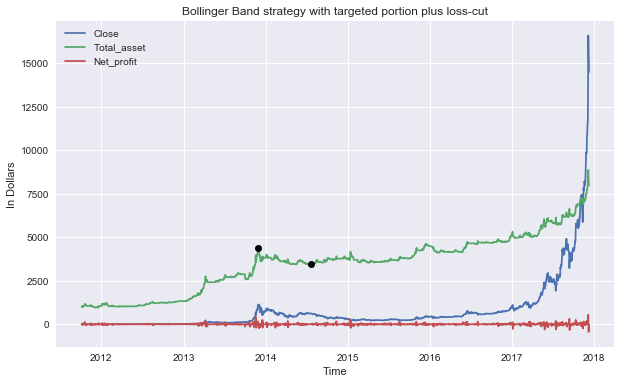

           Targeted portion = 0.3 , Loss cut = 0.95
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 6989.42
           The Quality of the Portfolio is 1.57
           Max Drawdown is -21.0 %


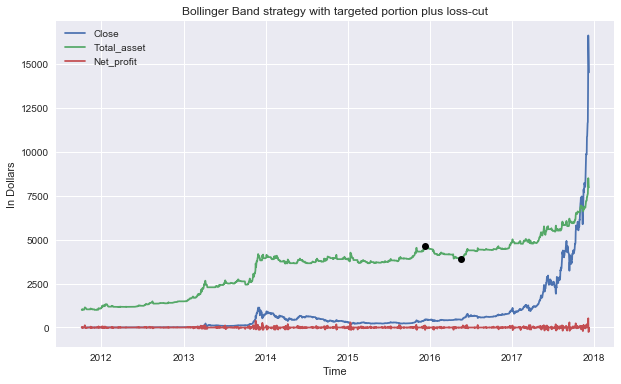

           Targeted portion = 0.3 , Loss cut = 0.97
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 6969.4
           The Quality of the Portfolio is 1.68
           Max Drawdown is -16.0 %


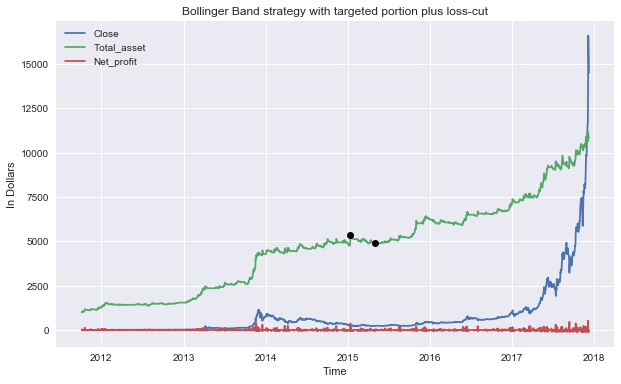

           Targeted portion = 0.3 , Loss cut = 0.99
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 9818.23
           The Quality of the Portfolio is 1.48
           Max Drawdown is -9.0 %


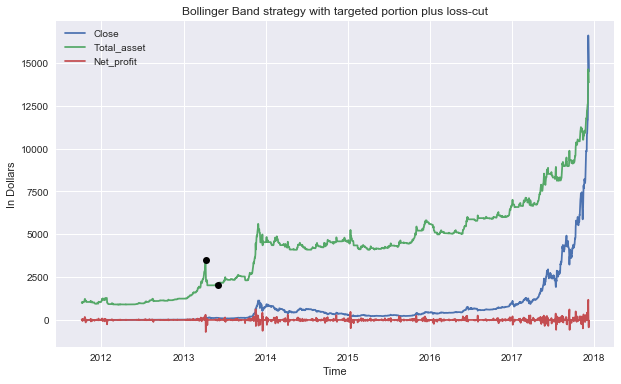

           Targeted portion = 0.4 , Loss cut = 0.8
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 12870.65
           The Quality of the Portfolio is 1.32
           Max Drawdown is -42.0 %


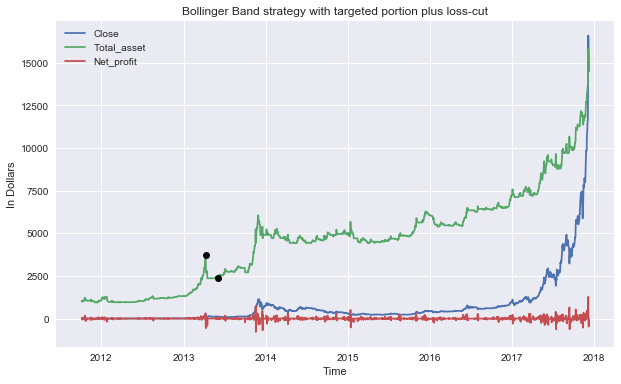

           Targeted portion = 0.4 , Loss cut = 0.85
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 13996.62
           The Quality of the Portfolio is 1.36
           Max Drawdown is -36.0 %


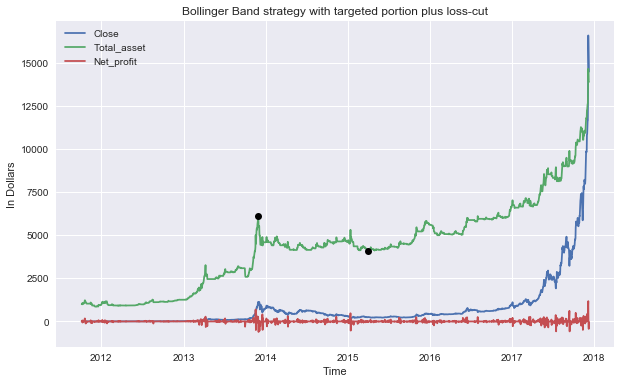

           Targeted portion = 0.4 , Loss cut = 0.9
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 12906.62
           The Quality of the Portfolio is 1.36
           Max Drawdown is -33.0 %


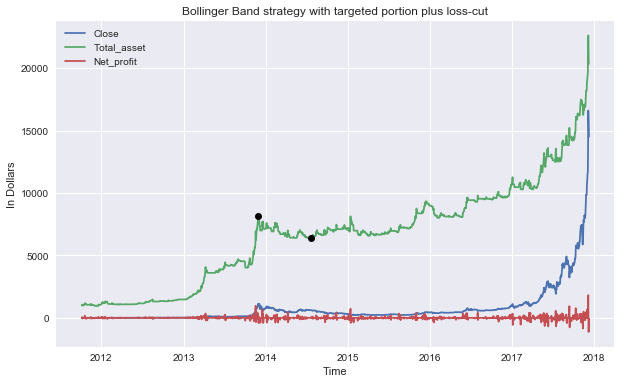

           Targeted portion = 0.4 , Loss cut = 0.95
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 19350.83
           The Quality of the Portfolio is 1.42
           Max Drawdown is -21.0 %


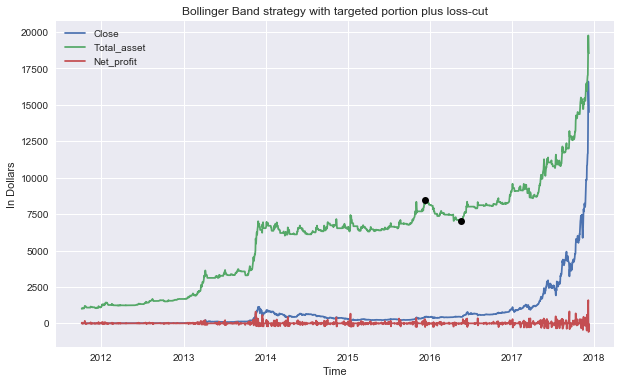

           Targeted portion = 0.4 , Loss cut = 0.97
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 17545.92
           The Quality of the Portfolio is 1.48
           Max Drawdown is -18.0 %


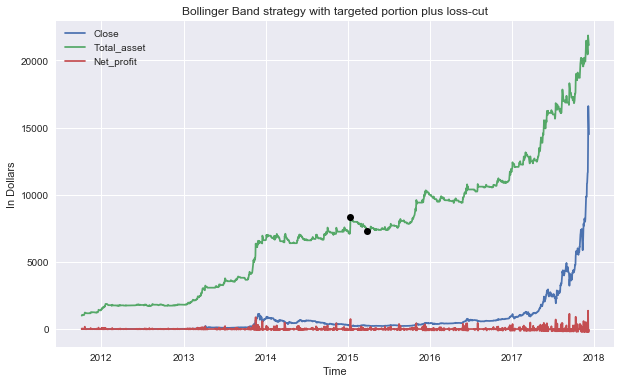

           Targeted portion = 0.4 , Loss cut = 0.99
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 20150.31
           The Quality of the Portfolio is 1.36
           Max Drawdown is -12.0 %


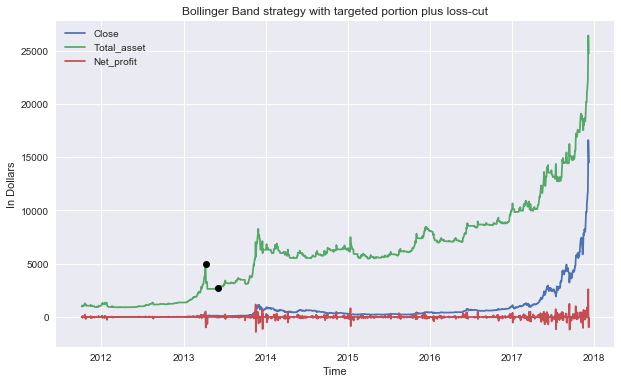

           Targeted portion = 0.5 , Loss cut = 0.8
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 23713.83
           The Quality of the Portfolio is 1.24
           Max Drawdown is -46.0 %


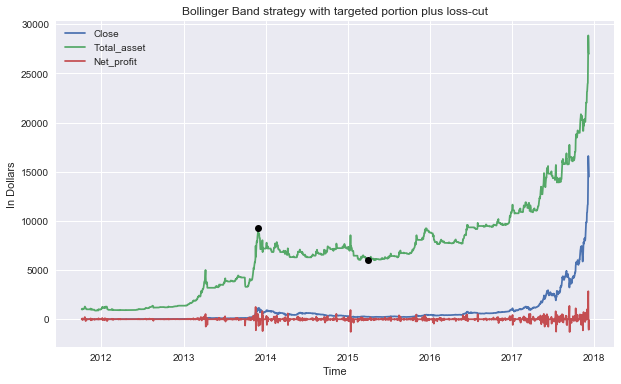

           Targeted portion = 0.5 , Loss cut = 0.85
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 26002.51
           The Quality of the Portfolio is 1.27
           Max Drawdown is -36.0 %


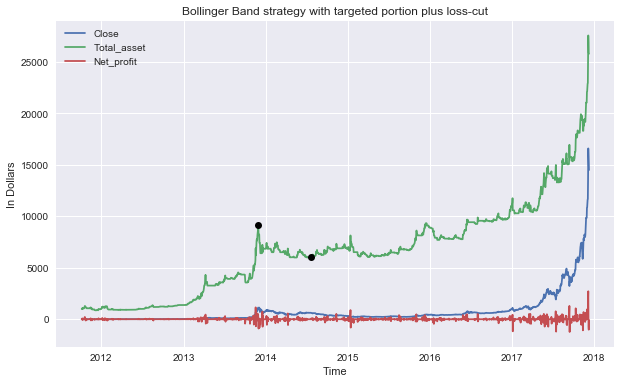

           Targeted portion = 0.5 , Loss cut = 0.9
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 24803.97
           The Quality of the Portfolio is 1.29
           Max Drawdown is -34.0 %


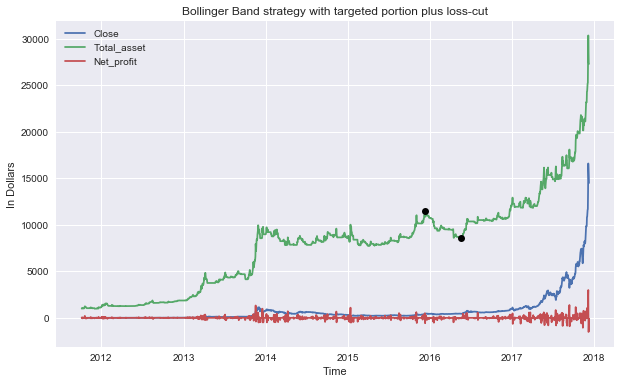

           Targeted portion = 0.5 , Loss cut = 0.95
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 26311.25
           The Quality of the Portfolio is 1.43
           Max Drawdown is -26.0 %


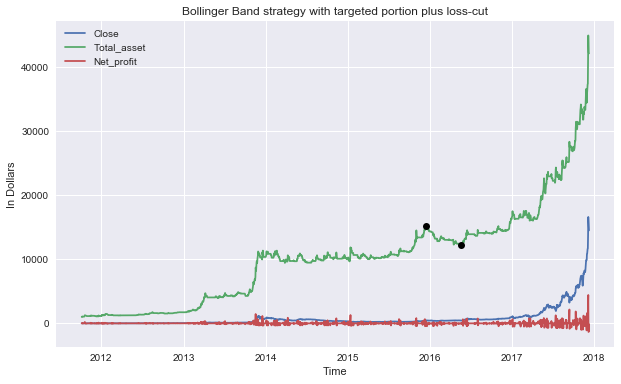

           Targeted portion = 0.5 , Loss cut = 0.97
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 41121.61
           The Quality of the Portfolio is 1.25
           Max Drawdown is -20.0 %


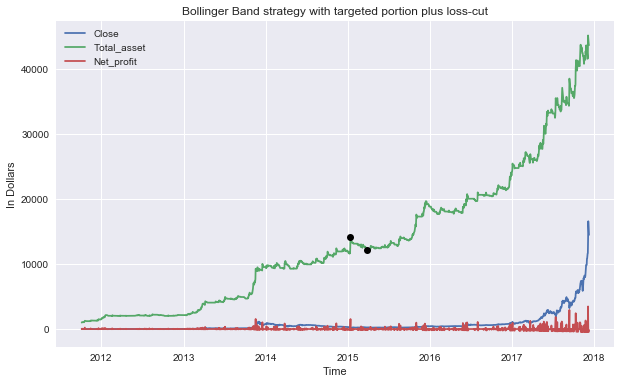

           Targeted portion = 0.5 , Loss cut = 0.99
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 42720.27
           The Quality of the Portfolio is 1.18
           Max Drawdown is -14.0 %


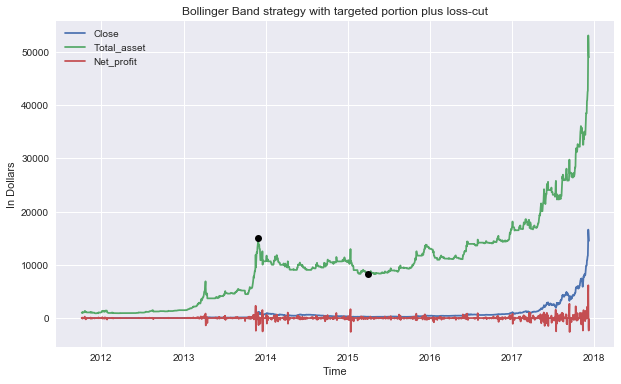

           Targeted portion = 0.6 , Loss cut = 0.8
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 47966.26
           The Quality of the Portfolio is 1.16
           Max Drawdown is -45.0 %


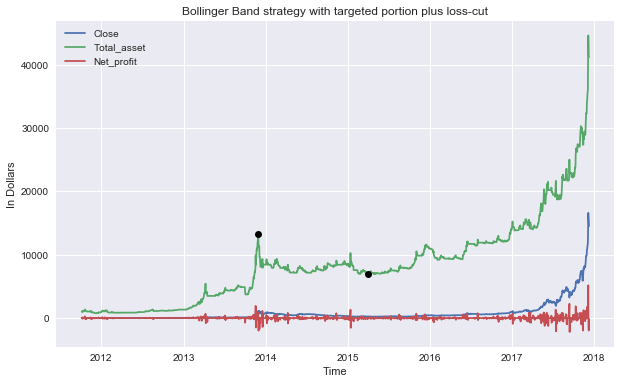

           Targeted portion = 0.6 , Loss cut = 0.85
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 40163.41
           The Quality of the Portfolio is 1.14
           Max Drawdown is -48.0 %


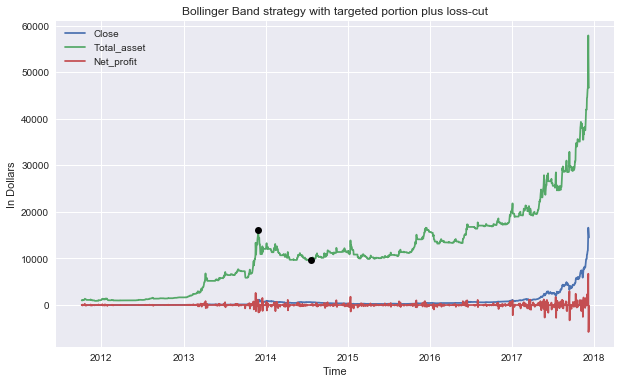

           Targeted portion = 0.6 , Loss cut = 0.9
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 45683.21
           The Quality of the Portfolio is 1.23
           Max Drawdown is -40.0 %


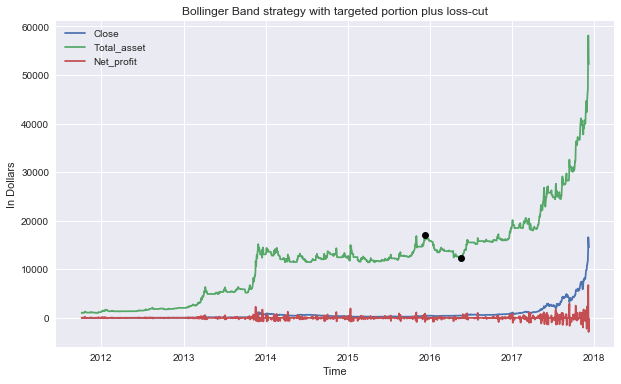

           Targeted portion = 0.6 , Loss cut = 0.95
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 51249.87
           The Quality of the Portfolio is 1.27
           Max Drawdown is -27.0 %


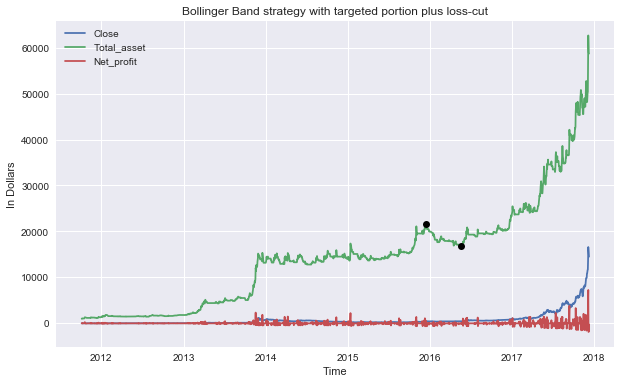

           Targeted portion = 0.6 , Loss cut = 0.97
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 57690.74
           The Quality of the Portfolio is 1.21
           Max Drawdown is -23.0 %


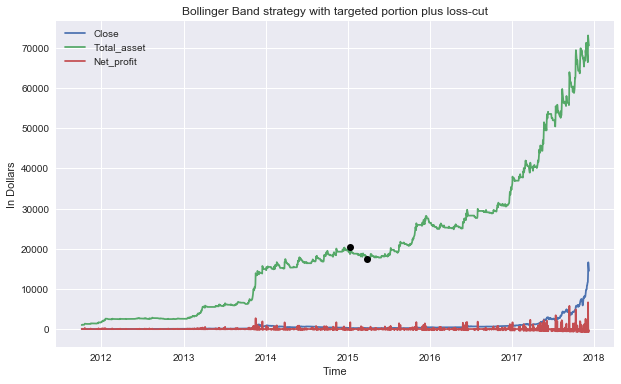

           Targeted portion = 0.6 , Loss cut = 0.99
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 69627.12
           The Quality of the Portfolio is 1.15
           Max Drawdown is -14.0 %


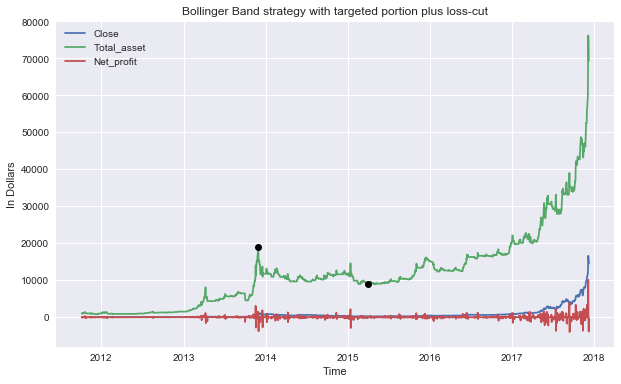

           Targeted portion = 0.7 , Loss cut = 0.8
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 68391.08
           The Quality of the Portfolio is 1.06
           Max Drawdown is -54.0 %


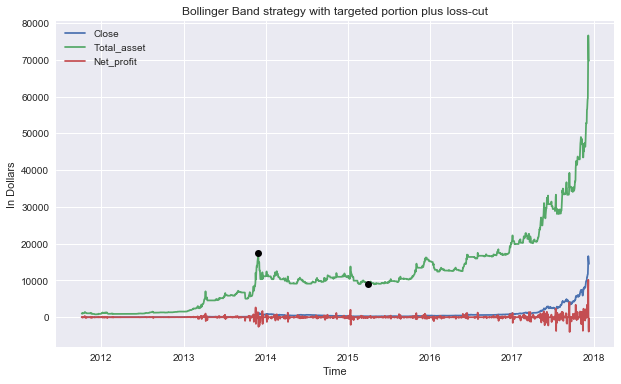

           Targeted portion = 0.7 , Loss cut = 0.85
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 68780.47
           The Quality of the Portfolio is 1.05
           Max Drawdown is -49.0 %


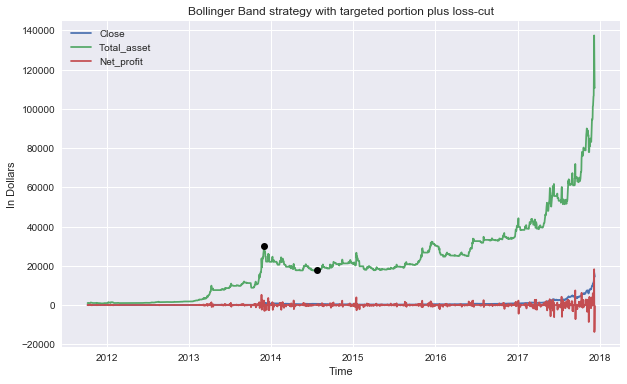

           Targeted portion = 0.7 , Loss cut = 0.9
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 109717.1
           The Quality of the Portfolio is 1.11
           Max Drawdown is -42.0 %


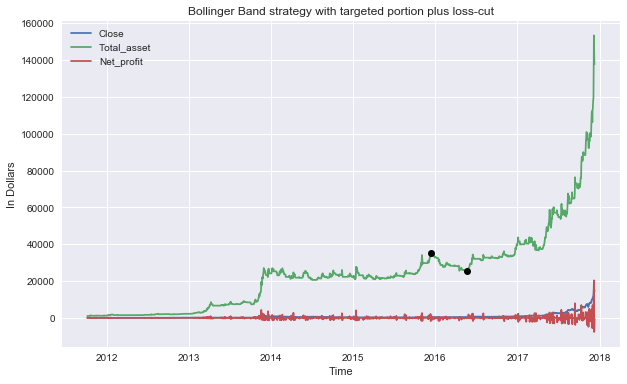

           Targeted portion = 0.7 , Loss cut = 0.95
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 136809.27
           The Quality of the Portfolio is 1.09
           Max Drawdown is -28.0 %


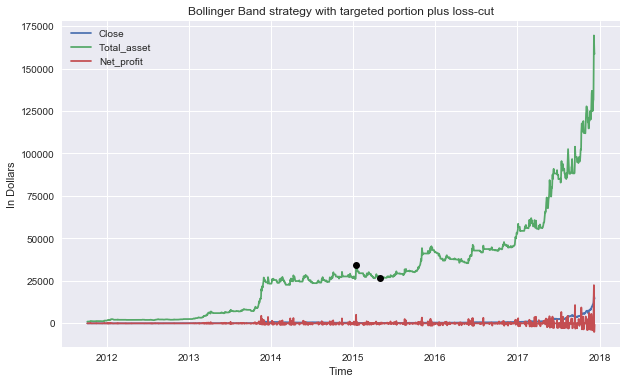

           Targeted portion = 0.7 , Loss cut = 0.97
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 157680.18
           The Quality of the Portfolio is 1.05
           Max Drawdown is -23.0 %


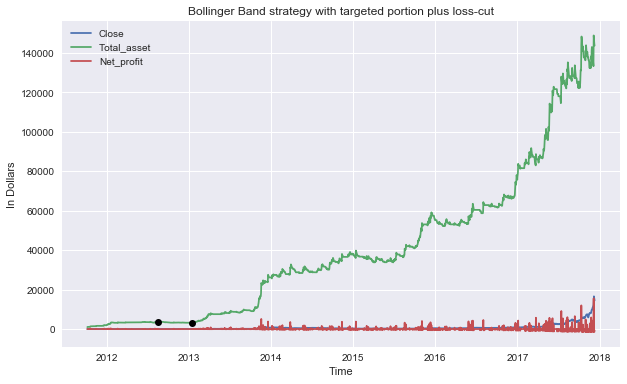

           Targeted portion = 0.7 , Loss cut = 0.99
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 142786.69
           The Quality of the Portfolio is 1.07
           Max Drawdown is -17.0 %


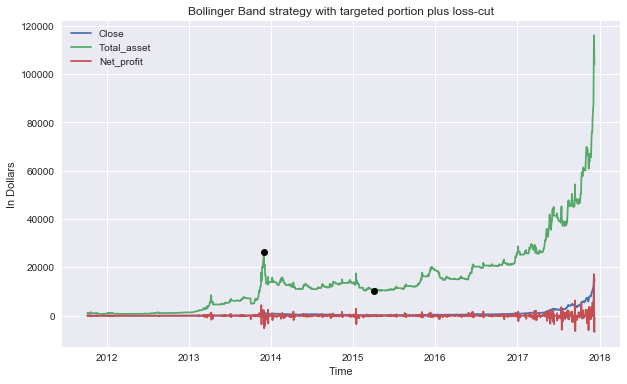

           Targeted portion = 0.8 , Loss cut = 0.8
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 103159.03
           The Quality of the Portfolio is 0.96
           Max Drawdown is -61.0 %


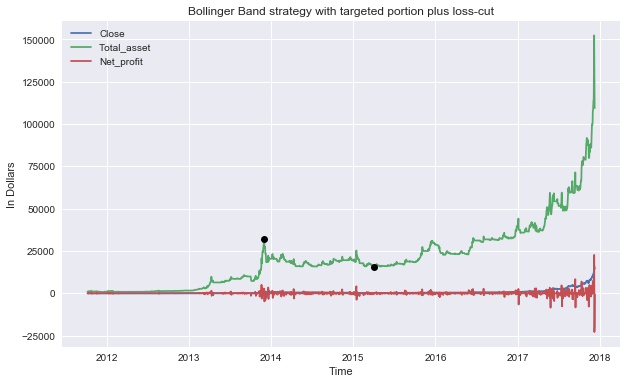

           Targeted portion = 0.8 , Loss cut = 0.85
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 108471.53
           The Quality of the Portfolio is 1.04
           Max Drawdown is -51.0 %


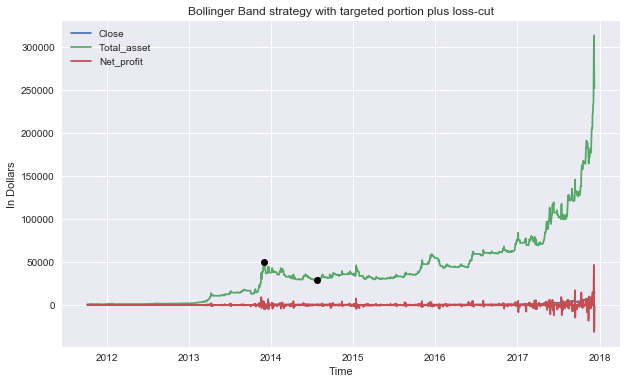

           Targeted portion = 0.8 , Loss cut = 0.9
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 251107.14
           The Quality of the Portfolio is 1.0
           Max Drawdown is -41.0 %


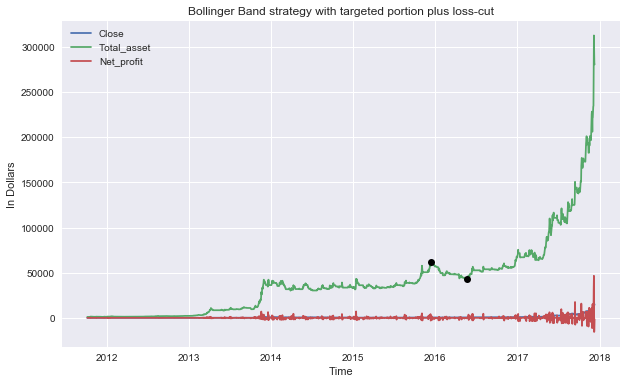

           Targeted portion = 0.8 , Loss cut = 0.95
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 279831.84
           The Quality of the Portfolio is 0.96
           Max Drawdown is -30.0 %


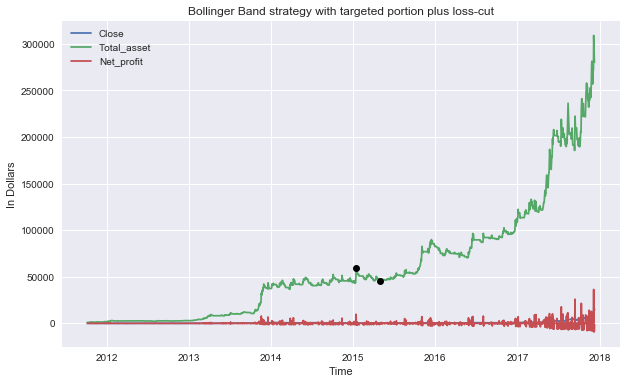

           Targeted portion = 0.8 , Loss cut = 0.97
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 279433.15
           The Quality of the Portfolio is 0.97
           Max Drawdown is -23.0 %


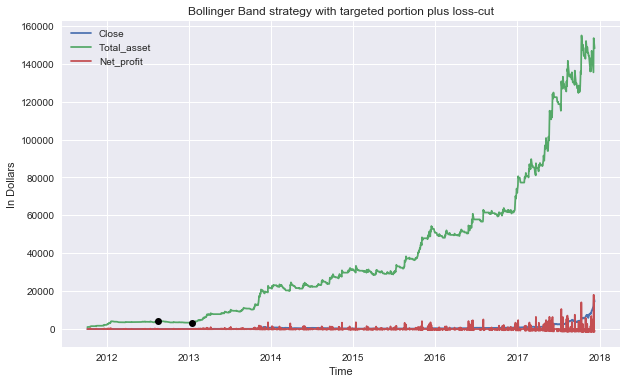

           Targeted portion = 0.8 , Loss cut = 0.99
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 147116.87
           The Quality of the Portfolio is 1.0
           Max Drawdown is -23.0 %


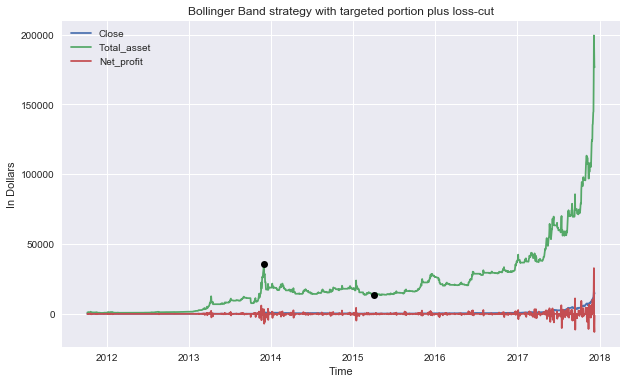

           Targeted portion = 0.9 , Loss cut = 0.8
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 175657.99
           The Quality of the Portfolio is 0.89
           Max Drawdown is -62.0 %


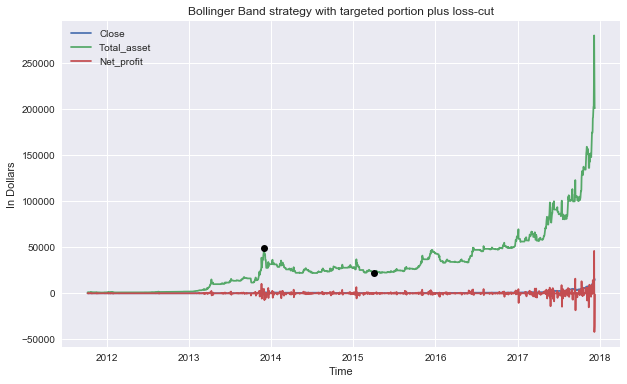

           Targeted portion = 0.9 , Loss cut = 0.85
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 200049.7
           The Quality of the Portfolio is 0.97
           Max Drawdown is -56.0 %


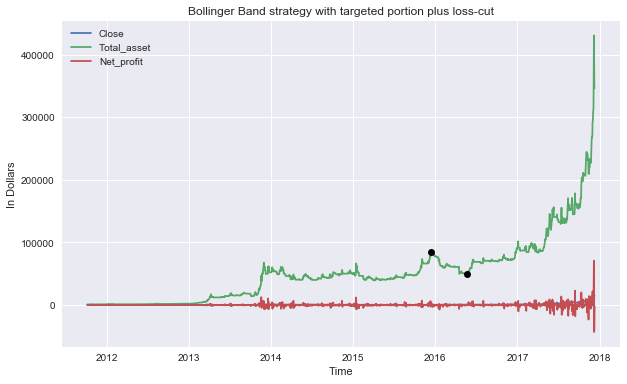

           Targeted portion = 0.9 , Loss cut = 0.9
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 345565.28
           The Quality of the Portfolio is 1.0
           Max Drawdown is -42.0 %


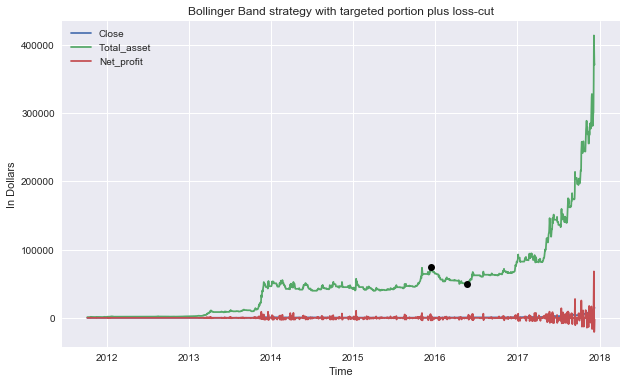

           Targeted portion = 0.9 , Loss cut = 0.95
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 369685.07
           The Quality of the Portfolio is 0.89
           Max Drawdown is -34.0 %


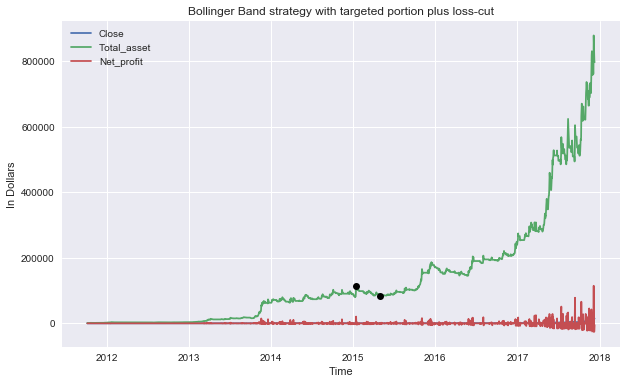

           Targeted portion = 0.9 , Loss cut = 0.97
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 794996.28
           The Quality of the Portfolio is 0.81
           Max Drawdown is -26.0 %


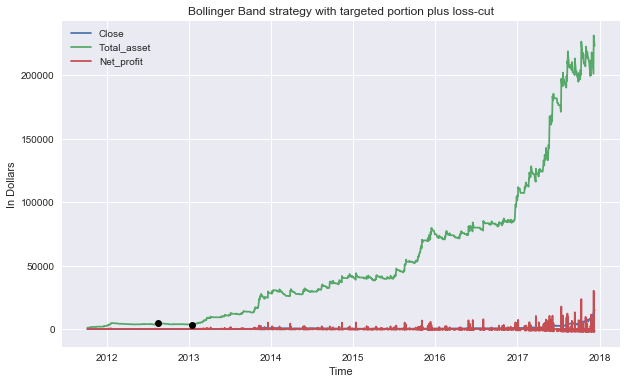

           Targeted portion = 0.9 , Loss cut = 0.99
           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 221960.02
           The Quality of the Portfolio is 0.95
           Max Drawdown is -23.0 %


In [196]:
test_portion_list = np.arange(0.3, 0.9, 0.1)         
loss_cut_list = [0.80, 0.85, 0.90, 0.95, 0.97, 0.99]
result_list = []
for portion in test_portion_list:
    for loss_cut in loss_cut_list:
        stock_df = simulate_algo(ref_stock_df, init_cash=1000, target_port_ratio=portion, loss_cut_ratio=loss_cut)
        record_ = calc_max_drawdown(stock_df)
        draw_result_of_sim(stock_df, record_)
        result_list.append([round(get_final_total_value(stock_df),2), round(calc_quality_of_port(stock_df),2), record_[0]]) 
        print('           Targeted portion =', portion,",",'Loss cut =',loss_cut)
        print('           Initial Investment Value $ 1000.00')
        print('           Final Portfolio Value: $', result_list[-1][0])
        print('           The Quality of the Portfolio is', result_list[-1][1])
        print('           Max Drawdown is', record_[0], '%')
        

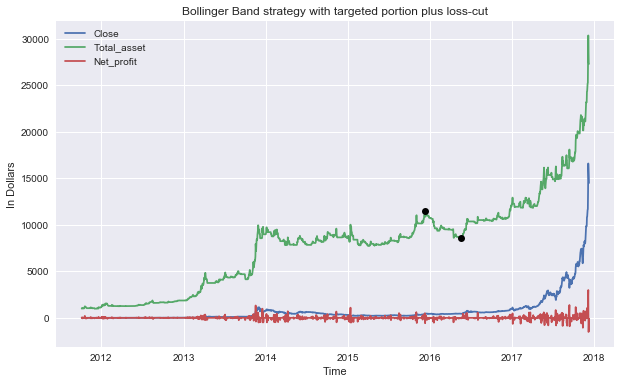

           Initial Investment Value $ 1000.00
           Final Portfolio Value: $ 26311.25
           The Quality of the Portfolio is 1.43
           Max Drawdown is -26.0 %


In [187]:
#example
stock_df = simulate_algo(ref_stock_df, init_cash=1000, target_port_ratio=0.5, loss_cut_ratio=0.95)
record_ = calc_max_drawdown(stock_df)
draw_result_of_sim(stock_df, record_)
print('           Initial Investment Value $ 1000.00')
print('           Final Portfolio Value: $', round(get_final_total_value(stock_df),2))
print('           The Quality of the Portfolio is', round(calc_quality_of_port(stock_df),2))
print('           Max Drawdown is', record_[0], '%')
